# Bolivian  Odds Data
## 2. Feature Matrix and Visual Exploration
This notebook seeks to explore the data through visualizations using seaborn and matplot lib and also to create new features based on team performance throughout each season

In [376]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
from collections import Counter
style.use('fivethirtyeight')
palette = "ch:-.2,2.5,dark=.3_r"


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Reading the prepared csv file
odds = pd.read_csv('/Users/miketondu/Dropbox/Data Science/Sharpest Minds/odds_data/bolivian_football_odds_clean.csv',
                   parse_dates=['date'])
odds.sort_values(by='date', inplace=True)

odds.shape

(20776, 38)

In [377]:
odds.head()

match                                         match_href  \
7758     La Paz - Blooming  https://www.oddsportal.com/soccer/bolivia/liga...   
4477  Real Potosi - Aurora  https://www.oddsportal.com/soccer/bolivia/liga...   
3250     La Paz - Blooming  https://www.oddsportal.com/soccer/bolivia/liga...   
5055  Real Potosi - Aurora  https://www.oddsportal.com/soccer/bolivia/liga...   
2743     Blooming - La Paz  https://www.oddsportal.com/soccer/bolivia/liga...   

       bookmakers  home_odds  draw_odds  away_odds  payout       date   time  \
7758         bwin       1.65       3.65       4.30    0.90 2008-10-19  19:30   
4477         bwin       1.88       3.35       3.55    0.90 2008-10-19  17:30   
3250  bet-at-home       1.65       3.50       3.95    0.87 2008-10-19  19:30   
5055  bet-at-home       1.85       3.25       3.40    0.88 2008-10-19  17:30   
2743  bet-at-home       1.50       3.45       5.40    0.88 2008-10-24  19:30   

      season_year    home_team away_team  implied_home_odds  \
7758         2008       La Paz  Blooming              0.606   
4477         2008  Real Potosi    Aurora              0.532   
3250         2008       La Paz  Blooming              0.606   
5055         2008  Real Potosi    Aurora              0.541   
2743         2008     Blooming    La Paz              0.667   

      implied_draw_odds  implied_away_odds final_result  home_goals  \
7758              0.274              0.233          2:1           2   
4477              0.299              0.282          1:1           1   
3250              0.286              0.253          2:1           2   
5055              0.308              0.294          1:1           1   
2743              0.290              0.185          5:0           5   

      away_goals  first_half_home  first_half_away  second_half_home  \
7758           1                1                0                 1   
4477           1                1                0                 0   
3250           1                1                0                 1   
5055           1                1                0                 0   
2743           0                2                0                 3   

      second_half_away  home_goals_allowed  away_goals_allowed  total_goals  \
7758                 1                   1                   2            3   
4477                 1                   1                   1            2   
3250                 1                   1                   2            3   
5055                 1                   1                   1            2   
2743                 0                   0                   5            5   

      total_first_half  total_second_half  win_home_or_away    winner  \
7758                 1                  2                 1    La Paz   
4477                 1                  1                 0      Draw   
3250                 1                  2                 1    La Paz   
5055                 1                  1                 0      Draw   
2743                 2                  3                 1  Blooming   

      home_win  away_win  home_loss  away_loss  home_points  away_points  \
7758         1         0          0          1            3            0   
4477         0         0          0          0            1            1   
3250         1         0          0          1            3            0   
5055         0         0          0          0            1            1   
2743         1         0          0          1            3            0   

      home_games_played  away_games_played  upset  
7758                  1                  1      0  
4477                  1                  1      0  
3250                  1                  1      0  
5055                  1                  1      0  
2743                  1                  1      0

## Feature Engineering
Create features based on location and running averages throughout the seasons on a per team preformance basis

### Altitude Feature
Whether the match was played in a high altitude location or not (3000m +)

In [378]:
# Create an altitude feature (Based on teams playing at 3600m above sea level+)
altitude = ['Bolivar', 'The Strongest', 'Real Potosi', 'San Jose',
            'Real Potosi','Nacional Potosi', 'Always Ready', 'La Paz' ]
odds['altitude'] = ''
for i in range(len(odds)):
    if (odds['home_team'].values[i] in altitude):
        odds['altitude'].values[i] = 1
    else:
        odds['altitude'].values[i] = 0


### Matrix Function Home/Away Results

Creates a matrix for wins/losses/points/games_played/goals_scored **as home team** and wins/losses/points/games_played/goals_scored **as away team** during each season.

In [379]:
# GOAL: make a function that will get you the number of wins for different columns (home_win, away_win,)
def matrix_func(dataframe, target_col):
    
    '''Creates a matrix for different game and team season attributes as home team
    or as away team '''
    
    team_1 = 'home_team' if 'home' in target_col else 'away_team'
    team_2 = 'away_team' if 'home' in target_col else 'home_team'
    
    # Keeping only unique matches
    df_unique = dataframe.drop_duplicates('match_href')
    # Creating reduced dataframe with TARGET_COL
    df_unique = df_unique.loc[:,[team_1,team_2,'date','season_year', target_col]]
    df_unique.sort_values(by='date',inplace=True)
    # Wide format data
    df_unique = df_unique.pivot_table(index=[team_1,'date','season_year'], 
                                  columns=team_2, 
                                  values=target_col,aggfunc=sum)
    # Creating incremental wins/losses column
    df_unique['incr'] = df_unique.apply(lambda x: x.sum(),axis=1)

    # Group_by team and season year
    df_unique = (df_unique.groupby([team_1, 'season_year'])
                 .cumsum()
                 .groupby([team_1, 'season_year'])
                 #.shift(1)
                 .fillna(0))
    df_unique.rename(columns={'incr':'cumulative_'+ target_col},inplace=True)
    df_unique = df_unique.iloc[:,-1:].reset_index()

    return df_unique

# Creating the new columns by running the matrix function
matrix_columns = ['home_win','away_win',
                  'home_loss', 'away_loss',
                  'home_points', 'away_points',
                  'home_games_played', 'away_games_played',
                  'home_goals', 'away_goals',
                  'home_goals_allowed','away_goals_allowed']
new_cols = []
for col in matrix_columns:
    new_cols.append(matrix_func(odds, col))

# Merging the new matrix columns to the orignal dataframe
for df in new_cols:
    team_location = df.columns[0]
    odds = odds.merge(df, on=[team_location, 'date','season_year'], how='left')




### Combine 'as_home' & 'as_away' Results

Combines the previously created columns into a single running total for each home and away team during any given season.


#### Features Created:
1. season_win_home_team 
2. season_win_away_team
3. season_loss_home_team
4. season_loss_away_team
5. season_points_home_team
6. season_points_away_team
7. season_games_played_home_team
8. season_games_played_away_team
9. season_goals_home_team
10. season_goals_away_team
11. season_goals_allowed_home_team
12. season_goals_allowed_away_team



In [380]:
def combine_home_away_func(dataframe,target_col):
    ''' Combine as_home and as_away for the chosen 
    target col: win, loss, points, games_played, goals, goals_allowed'''

    game_home = (dataframe.drop_duplicates('match_href')
                 .loc[:,['home_team', 'date', 'season_year', 'cumulative_home_'+target_col]]
                 .sort_values(by=['home_team', 'date']))
    game_away = (dataframe.drop_duplicates('match_href')
                 .loc[:,['away_team', 'date', 'season_year', 'cumulative_away_'+target_col]]
                 .sort_values(by=['away_team', 'date']))

    # renaming home_team and away_team to 'team'
    game_home.rename(columns={'home_team':'team'},inplace=True)
    game_away.rename(columns={'away_team':'team'},inplace=True)

    # Concatenating the two datagrames 
    game_of_season = (pd.concat([game_home,game_away]))
    game_of_season['team_temp'] = game_of_season['team'] #temporary team variable copied for merging purposes
    game_of_season = (game_of_season
                      .sort_values(by=['team_temp','season_year','date'])
                      .reset_index(drop=True)
                      .groupby(['team_temp', 'season_year'])
                      .fillna(method='ffill')
                      .fillna(0)
                      )

    # Create the single column 
    game_of_season['season_'+target_col] = pd.DataFrame(game_of_season['cumulative_home_'+target_col] + game_of_season['cumulative_away_'+target_col])
    game_of_season = pd.DataFrame(game_of_season.loc[:,['team','date', 'season_'+target_col]])
    
    ## Create new year season to groupby again and shift by one to avoid data leakage
    game_of_season['year'] = game_of_season['date'].dt.year
    game_of_season['season_'+target_col] = (game_of_season
                                                    .groupby(['team', 'year'])['season_'+target_col]
                                                    .shift()
                                                    .fillna(0))
    return game_of_season


# Creating the new columns by running the matrix function
target_cols = ['win', 'loss', 'points','games_played','goals','goals_allowed']
new_cols = []
for col in target_cols:
    new_cols.append(combine_home_away_func(odds, col))

# Merging the new combined columns 
for df in new_cols:

    odds = (odds.merge(df, left_on=['home_team','date'],
              right_on=['team','date'], how='left')
            .rename(columns={df.columns[2]:df.columns[2]+'_home_team'})
           )
    # Merging the win columns for away team
    odds =  (odds.merge(df, left_on=['away_team','date'],
              right_on=['team','date'], how='left')
             .rename(columns={df.columns[2]:df.columns[2]+'_away_team'})
            )

    
# Dropping duplicate columns
odds.drop(['team_x', 'team_y', 'year_x', 'year_y'],axis=1,inplace=True)

/Users/miketondu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [382]:
# Dropping columns which are no longer useful
#odds.drop_duplicates('match_href').head(1000)

odds.drop([ 'home_odds', 'draw_odds',
            'away_odds','final_result',
            'away_win', 'home_loss', 'away_loss', 
            'home_points', 'away_points',
            'home_games_played',
            'away_games_played',
            'cumulative_home_win', 'cumulative_away_win',
            'cumulative_home_loss', 'cumulative_away_loss','cumulative_home_points',
            'cumulative_away_points','cumulative_home_games_played',
            'cumulative_away_games_played','cumulative_home_goals_allowed', 'cumulative_away_goals_allowed']
          ,axis=1,inplace=True)

## Visualization and Exploration

The purpose of this section is to visually explore the data in order to find interesting trends and patterns that could become relevant features in the modelling phase.

In [383]:
odds_unique_matches = odds.drop_duplicates('match_href')
odds_unique_matches.columns
odds_unique_matches.shape

Index(['match', 'match_href', 'bookmakers', 'payout', 'date', 'time',
       'season_year', 'home_team', 'away_team', 'implied_home_odds',
       'implied_draw_odds', 'implied_away_odds', 'home_goals', 'away_goals',
       'first_half_home', 'first_half_away', 'second_half_home',
       'second_half_away', 'home_goals_allowed', 'away_goals_allowed',
       'total_goals', 'total_first_half', 'total_second_half',
       'win_home_or_away', 'winner', 'home_win', 'upset', 'altitude',
       'cumulative_home_goals', 'cumulative_away_goals',
       'season_win_home_team', 'season_win_away_team', 'season_loss_home_team',
       'season_loss_away_team', 'season_points_home_team',
       'season_points_away_team', 'season_games_played_home_team',
       'season_games_played_away_team', 'season_goals_home_team',
       'season_goals_away_team', 'season_goals_allowed_home_team',
       'season_goals_allowed_away_team'],
      dtype='object')

(2840, 42)

In [364]:
odds_unique_matches.head(1000)

match  \
0                            La Paz - Blooming   
1                         Real Potosi - Aurora   
4                            Blooming - La Paz   
6                            Aurora - Blooming   
7                       Real Potosi - U. Sucre   
8                        Real Mamore - Guabira   
10                     Bolivar - The Strongest   
11                        Wilstermann - Aurora   
15                Blooming - Oriente Petrolero   
17                        Aurora - Wilstermann   
18                       Guabira - Real Mamore   
22                    San Jose - The Strongest   
24                  Aurora - Oriente Petrolero   
28                       Bolivar - Wilstermann   
30                   Real Mamore - Real Potosi   
31                           Blooming - La Paz   
36                        Real Potosi - La Paz   
37                      U. Sucre - Wilstermann   
40                 The Strongest - Real Potosi   
41                             La Paz - Aurora   
43                      Wilstermann - U. Sucre   
44                         San Jose - Blooming   
47                   Bolivar - Nacional Potosi   
48                  Aurora - Oriente Petrolero   
52                        La Paz - Real Potosi   
53                         Blooming - U. Sucre   
54                       Bolivar - Wilstermann   
57                 Real Mamore - The Strongest   
59                  Nacional Potosi - San Jose   
71                      Wilstermann - Blooming   
72                          San Jose - Bolivar   
77                   Real Potosi - Real Mamore   
78                  U. Sucre - Nacional Potosi   
79                  Oriente Petrolero - La Paz   
83                      The Strongest - Aurora   
89                           La Paz - San Jose   
90                      U. Sucre - Real Mamore   
91                        Wilstermann - Aurora   
92               Nacional Potosi - Real Potosi   
93                     The Strongest - Bolivar   
94                Blooming - Oriente Petrolero   
104            Oriente Petrolero - Real Mamore   
106                       Aurora - Real Mamore   
107                 Nacional Potosi - Blooming   
110                     La Paz - The Strongest   
112            Oriente Petrolero - Real Potosi   
114                     San Jose - Wilstermann   
118          The Strongest - Oriente Petrolero   
119                       Real Potosi - Aurora   
122                        U. Sucre - San Jose   
123              Wilstermann - Nacional Potosi   
126                  Nacional Potosi - Bolivar   
128                        Blooming - San Jose   
129                     U. Sucre - Wilstermann   
130            Real Mamore - Oriente Petrolero   
135                            Aurora - La Paz   
140                         Blooming - Bolivar   
143                     Real Mamore - U. Sucre   
144                          San Jose - La Paz   
145                    Bolivar - The Strongest   
148              Real Potosi - Nacional Potosi   
154                      Wilstermann - Bolivar   
157                 Nacional Potosi - U. Sucre   
161                  Real Mamore - Real Potosi   
162                     Aurora - The Strongest   
165                 La Paz - Oriente Petrolero   
167                     Blooming - Wilstermann   
169                         Bolivar - San Jose   
177                       Real Mamore - La Paz   
179                        U. Sucre - Blooming   
183                 Blooming - Nacional Potosi   
184            Real Potosi - Oriente Petrolero   
187                     The Strongest - La Paz   
193                        San Jose - U. Sucre   
195                         Bolivar - Blooming   
196                       Aurora - Real Potosi   
199          Oriente Petrolero - The Strongest   
209                       La Paz - Real Mamore   
211              Nacional Potosi - Wilstermann   
215                     Blooming - Real P

### Teams
This section will focus on individual teams and their overall performance

In [340]:
odds_unique_matches.loc[:,['match','date','winner',
       #'season_wins_home_team', 'season_wins_away_team',
       #'season_losses_home_team', 'season_losses_away_team',
       #'game_of_season_home_team', 'game_of_season_away_team',
       'season_points_home_team', 'season_points_away_team'
                          ]]

match       date  \
0                             La Paz - Blooming 2008-10-19   
1                          Real Potosi - Aurora 2008-10-19   
4                             Blooming - La Paz 2008-10-24   
6                             Aurora - Blooming 2008-10-29   
7                        Real Potosi - U. Sucre 2008-11-09   
8                         Real Mamore - Guabira 2008-11-09   
10                      Bolivar - The Strongest 2008-11-09   
11                         Wilstermann - Aurora 2008-11-09   
15                 Blooming - Oriente Petrolero 2008-11-11   
17                         Aurora - Wilstermann 2008-11-16   
18                        Guabira - Real Mamore 2008-11-16   
22                     San Jose - The Strongest 2008-11-22   
24                   Aurora - Oriente Petrolero 2008-11-22   
28                        Bolivar - Wilstermann 2008-11-23   
30                    Real Mamore - Real Potosi 2008-11-23   
31                            Blooming - La Paz 2008-11-23   
36                         Real Potosi - La Paz 2008-12-18   
37                       U. Sucre - Wilstermann 2009-07-05   
40                  The Strongest - Real Potosi 2009-07-18   
41                              La Paz - Aurora 2009-07-19   
43                       Wilstermann - U. Sucre 2009-07-19   
44                          San Jose - Blooming 2009-07-19   
47                    Bolivar - Nacional Potosi 2009-07-19   
48                   Aurora - Oriente Petrolero 2009-07-25   
52                         La Paz - Real Potosi 2009-07-26   
53                          Blooming - U. Sucre 2009-07-26   
54                        Bolivar - Wilstermann 2009-07-26   
57                  Real Mamore - The Strongest 2009-07-26   
59                   Nacional Potosi - San Jose 2009-07-26   
71                       Wilstermann - Blooming 2009-07-30   
72                           San Jose - Bolivar 2009-07-30   
77                    Real Potosi - Real Mamore 2009-07-31   
78                   U. Sucre - Nacional Potosi 2009-07-31   
79                   Oriente Petrolero - La Paz 2009-07-31   
83                       The Strongest - Aurora 2009-07-31   
89                            La Paz - San Jose 2009-08-01   
90                       U. Sucre - Real Mamore 2009-08-02   
91                         Wilstermann - Aurora 2009-08-02   
92                Nacional Potosi - Real Potosi 2009-08-02   
93                      The Strongest - Bolivar 2009-08-02   
94                 Blooming - Oriente Petrolero 2009-08-02   
104             Oriente Petrolero - Real Mamore 2009-08-06   
106                        Aurora - Real Mamore 2009-08-08   
107                  Nacional Potosi - Blooming 2009-08-08   
110                      La Paz - The Strongest 2009-08-09   
112             Oriente Petrolero - Real Potosi 2009-08-09   
114                      San Jose - Wilstermann 2009-08-09   
118           The Strongest - Oriente Petrolero 2009-08-12   
119                        Real Potosi - Aurora 2009-08-12   
122                         U. Sucre - San Jose 2009-08-14   
123               Wilstermann - Nacional Potosi 2009-08-14   
126                   Nacional Potosi - Bolivar 2009-08-16   
128                         Blooming - San Jose 2009-08-16   
129                      U. Sucre - Wilstermann 2009-08-16   
130             Real Mamore - Oriente Petrolero 2009-08-16   
135                             Aurora - La Paz 2009-08-16   
140                          Blooming - Bolivar 2009-08-20   
143                      Real Mamore - U. Sucre 2009-08-23   
144                           San Jose - La Paz 2009-08-23   
145                     Bolivar - The Strongest 2009-08-23   
148               Real Potosi - Nacional Potosi 2009-08-23   
154                       Wilstermann - Bolivar 2009-08-28   
157                  Nacional Potosi - U. Sucre 2009-08-29   
161                   Real Mamore - Real Potosi 2009-08-30   
162         

#### Altitude Advantage

Teams playing as home team in high altitude locations, tend to win 10% more often.


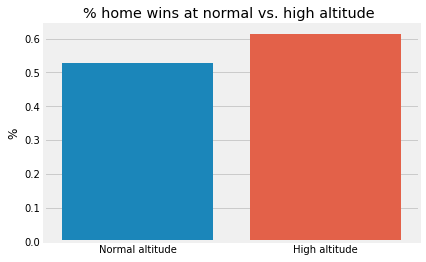

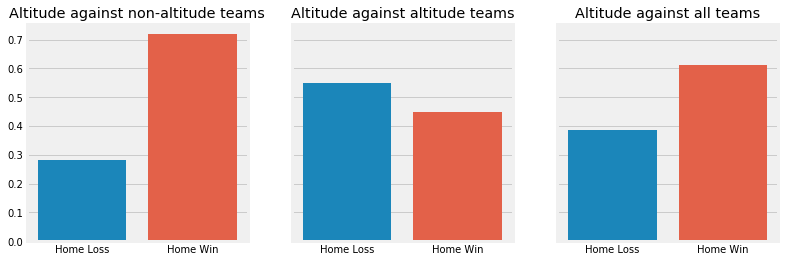

In [349]:
# Percentage home wins in high altitude games for all teams
data = odds_unique_matches.groupby('altitude')['home_win'].apply(lambda x: sum(x)/len(x))
data
fig, axes= plt.subplots(figsize=(6,4))
sns.barplot(data.index, data)

plt.title('% home wins at normal vs. high altitude ')
axes.set_xticklabels(['Normal altitude', 'High altitude'])
axes.set_xlabel('')
axes.set_ylabel('%');

print('Teams playing as home team in high altitude locations, tend to win 10% more often.');


# Percentage wins for home team in altitude playing against low altitude teams 
altitude = ['Bolivar', 'The Strongest', 'Real Potosi', 'San Jose',
            'Real Potosi','Nacional Potosi', 'Always Ready', 'La Paz' ]

# Creating figure for plots
fig, axes= plt.subplots(1,3,figsize=(12,4),sharey=True)

# Subsetting low altitude away teams vs altitude home teams
data = odds_unique_matches.loc[(odds_unique_matches['altitude'] == 1) 
                               & (~odds_unique_matches['away_team'].isin(altitude))]
data = data.home_win.value_counts(normalize=True)
data
# Graph 1
sns.barplot(data.index, data, ax=axes[0])

axes[0].set_title('Altitude against non-altitude teams')
axes[0].set_xticklabels(['Home Loss', 'Home Win'])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Percentage wins for home team in altitude playing against other high altitude teams 
# Subsetting low altitude away teams vs altitude home teams
data = odds_unique_matches.loc[(odds_unique_matches['altitude'] == 1) 
                               & (odds_unique_matches['away_team'].isin(altitude))]
data = data.home_win.value_counts(normalize=True)
data
# Graph 2
sns.barplot(data.index, data, ax=axes[1])
axes[1].set_title('Altitude against altitude teams')
axes[1].set_xticklabels(['Home Loss', 'Home Win'])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Percentage wins for home team in altitude playing against all teams 
# Subsetting low altitude away teams vs altitude home teams

data = odds_unique_matches.loc[(odds_unique_matches['altitude'] == 1)]
data = data.home_win.value_counts(normalize=True)
data
# Graph 3
sns.barplot(data.index, data, ax = axes[2])
axes[2].set_title('Altitude against all teams')
axes[2].set_xticklabels(['Home Loss', 'Home Win'])
axes[2].set_xlabel('')
axes[2].set_ylabel('');


- High altitude teams playing at home against low altitude teams win about 72% of the time
- High altitude teams playing at home against other high altitude teams win only 45% of the time (interesting)
- High altitude teams playing at home win  61% of the time on average



#### Win Rate

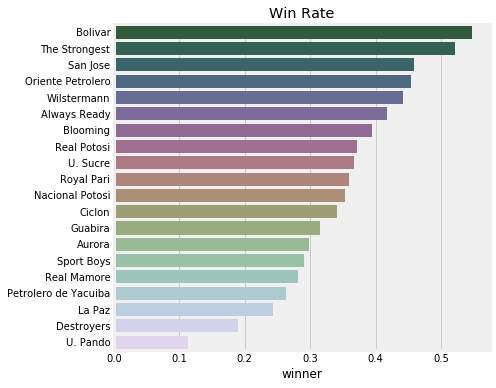

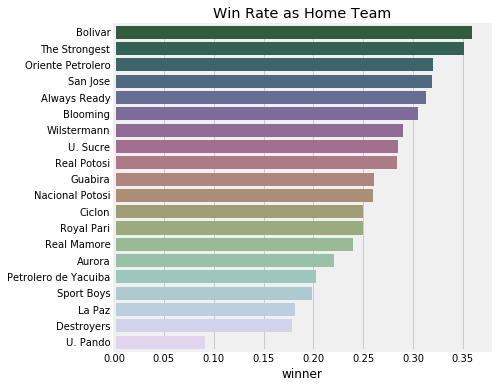

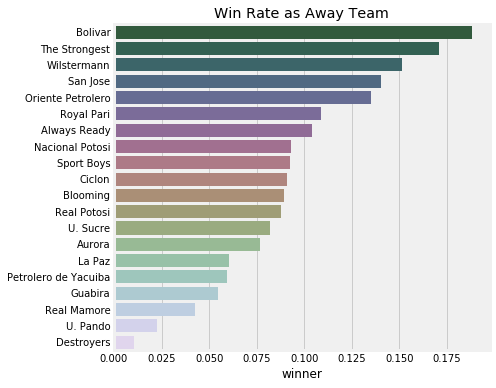

In [345]:
#### Highest win percentage ###

# Number of games won per team
data = odds_unique_matches.winner.value_counts()
data.index.unique()
data.values

# Number of games played per team
games_played=[]
for i in data.index:
    games_played.append(len((odds_unique_matches.loc[(odds_unique_matches['home_team']==i) 
                                                     | (odds_unique_matches['away_team']==i) ])))
    
# Win rate
data = data/games_played
data= data[1:].sort_values(ascending=False)

# Graph
fig, axes= plt.subplots(figsize=(6,6))
sns.barplot(y=data.index, x=data, palette=palette)
axes.set_title('Win Rate');

### Highest win percentage as home team ###
data = (odds_unique_matches['winner']
        .loc[odds_unique_matches['win_home_or_away']==1]
        .value_counts())

# Number of games played per team
games_played=[]
for i in data.index:
    games_played.append(len((odds_unique_matches.loc[(odds_unique_matches['home_team']==i) 
                                                     | (odds_unique_matches['away_team']==i) ])))
    
# Win rate as away team
data = data/games_played
data= data.sort_values(ascending=False)

# Graph
fig, axes= plt.subplots(figsize=(6,6))
sns.barplot(y=data.index, x=data, palette=palette)
axes.set_title('Win Rate as Home Team');

### Highest win percentage as away team ###
data = (odds_unique_matches['winner']
        .loc[odds_unique_matches['win_home_or_away']==2]
        .value_counts())

# Number of games played per team
games_played=[]
for i in data.index:
    games_played.append(len((odds_unique_matches.loc[(odds_unique_matches['home_team']==i) 
                                                     | (odds_unique_matches['away_team']==i) ])))
    
# Win rate as away team
data = data/games_played
data= data.sort_values(ascending=False)

# Graph
fig, axes= plt.subplots(figsize=(6,6))
sns.barplot(y=data.index, x=data, palette=palette)
axes.set_title('Win Rate as Away Team');

In [375]:
#sns.lineplot(data=odds_unique_matches, x='game_of_season_home_team', y ='season_wins_home_team', ci='sd')


/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


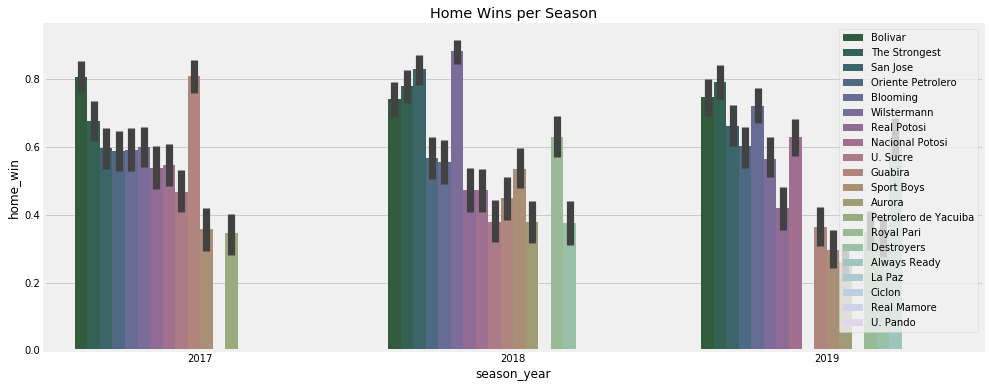

In [76]:
# Home Wins per Season
fig,axes = plt.subplots(figsize=(15,6))
sns.barplot(data=odds[(odds['date']>'2017')],
             x = 'season_year', y='home_win',hue='home_team',
            hue_order = odds.groupby('home_team')['home_win'].sum().sort_values(ascending=False).index,
           palette=palette)


plt.legend(loc='upper right')
plt.xticks(rotation=0)
plt.title('Home Wins per Season')
plt.show();

#### Goals

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


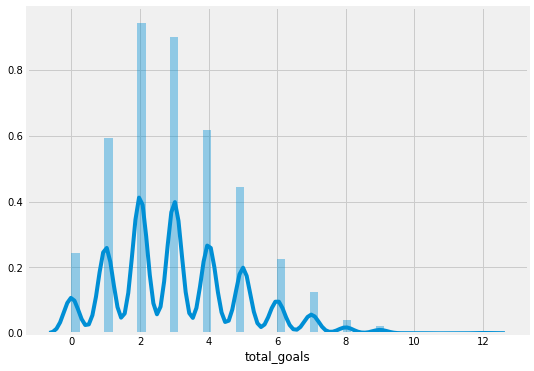

In [369]:
# Goal distributions for all teams in all matches
fig, axes = plt.subplots(figsize=(8,6))
sns.distplot(odds['total_goals'])
odds.total_goals.value_counts();

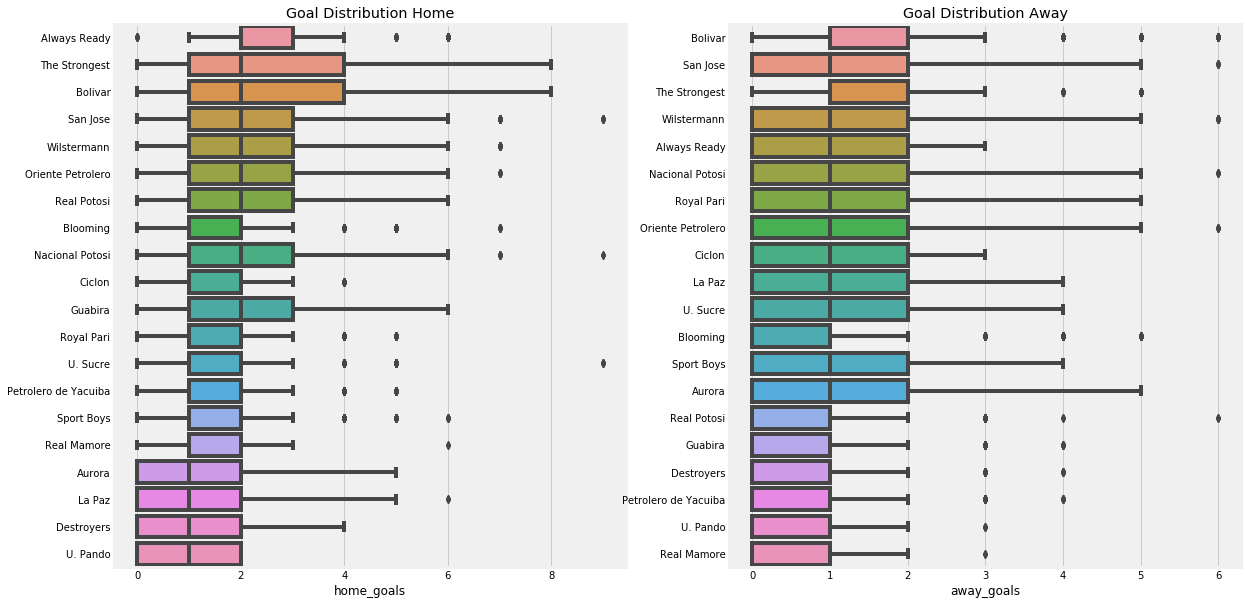

In [370]:
# goals distribution per team boxplot 
fig, axes = plt.subplots(1,2,figsize=(18,10))
sns.boxplot(data=odds ,
            y='home_team', x='home_goals', ax=axes[0], 
            order=odds.groupby('home_team')['home_goals'].mean().sort_values(ascending=False).index)

sns.boxplot(data=odds ,
            y='away_team', x='away_goals',ax=axes[1],
           order=odds.groupby('away_team')['away_goals'].mean().sort_values(ascending=False).index)

plt.title('Goal Distribution')
plt.xticks(rotation=0)
axes[0].set_ylabel('')
axes[1].set_ylabel('')


axes[0].set_title('Goal Distribution Home')
axes[1].set_title('Goal Distribution Away')
plt.xticks(rotation=0);



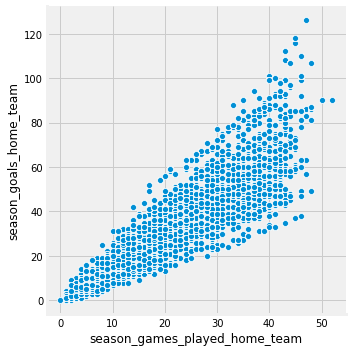

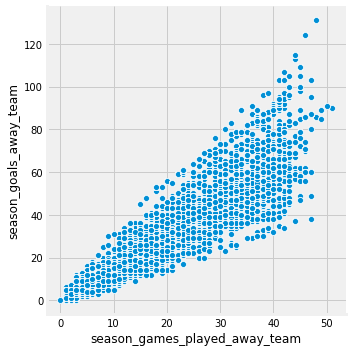

In [391]:
# Total goals scored as season progresses
#fig, axes = plt.subplots(figsize=(4,6))
sns.relplot(data=odds, x='season_games_played_home_team', y='season_goals_home_team');
sns.relplot(data=odds, x='season_games_played_away_team', y='season_goals_away_team');

In [403]:
odds.columns

Index(['match', 'match_href', 'bookmakers', 'payout', 'date', 'time',
       'season_year', 'home_team', 'away_team', 'implied_home_odds',
       'implied_draw_odds', 'implied_away_odds', 'home_goals', 'away_goals',
       'first_half_home', 'first_half_away', 'second_half_home',
       'second_half_away', 'home_goals_allowed', 'away_goals_allowed',
       'total_goals', 'total_first_half', 'total_second_half',
       'win_home_or_away', 'winner', 'home_win', 'upset', 'altitude',
       'cumulative_home_goals', 'cumulative_away_goals',
       'season_win_home_team', 'season_win_away_team', 'season_loss_home_team',
       'season_loss_away_team', 'season_points_home_team',
       'season_points_away_team', 'season_games_played_home_team',
       'season_games_played_away_team', 'season_goals_home_team',
       'season_goals_away_team', 'season_goals_allowed_home_team',
       'season_goals_allowed_away_team'],
      dtype='object')

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'La Paz')

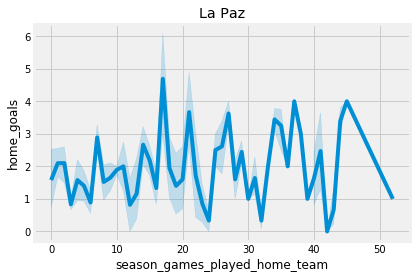

Text(0.5,1,'Real Potosi')

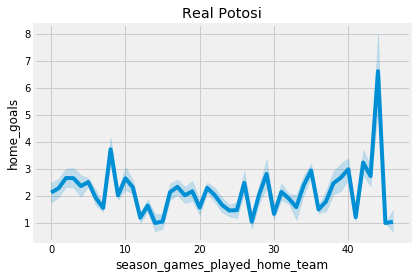

Text(0.5,1,'Blooming')

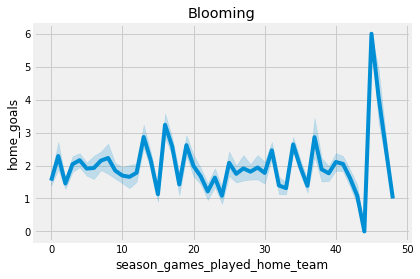

Text(0.5,1,'Aurora')

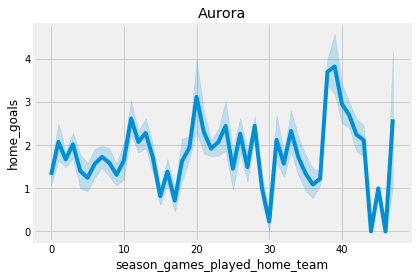

Text(0.5,1,'Real Mamore')

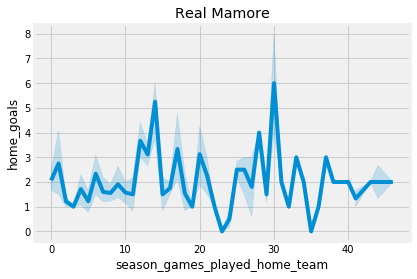

Text(0.5,1,'Bolivar')

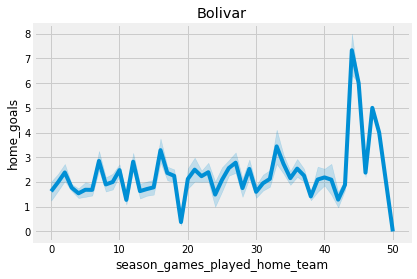

Text(0.5,1,'Wilstermann')

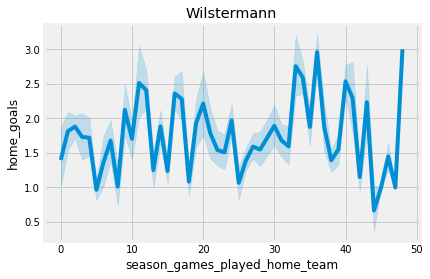

Text(0.5,1,'Guabira')

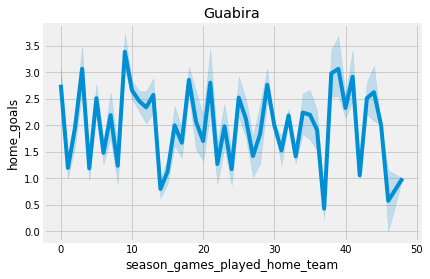

Text(0.5,1,'San Jose')

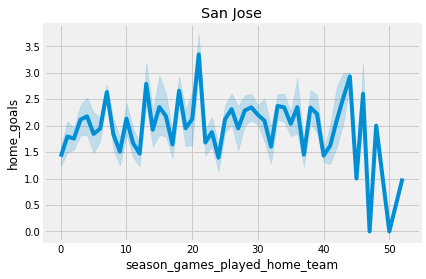

Text(0.5,1,'U. Sucre')

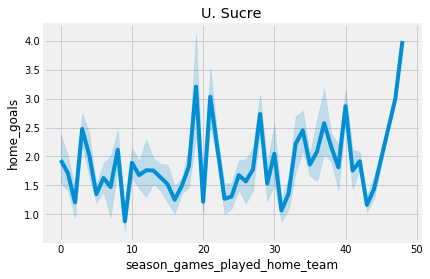

Text(0.5,1,'The Strongest')

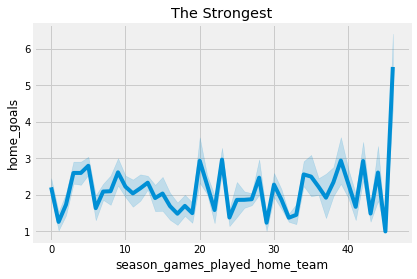

Text(0.5,1,'Nacional Potosi')

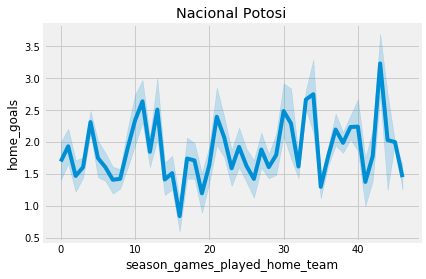

Text(0.5,1,'Oriente Petrolero')

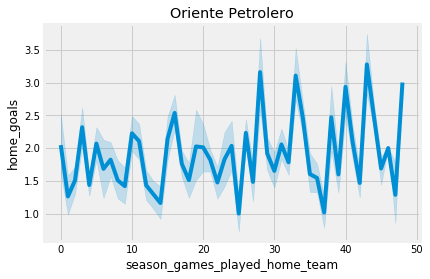

Text(0.5,1,'Destroyers')

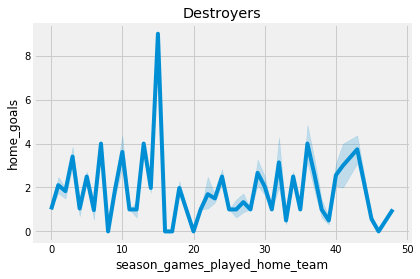

Text(0.5,1,'Petrolero de Yacuiba')

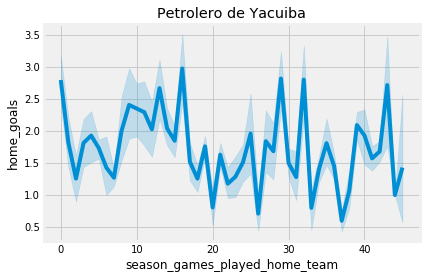

Text(0.5,1,'Sport Boys')

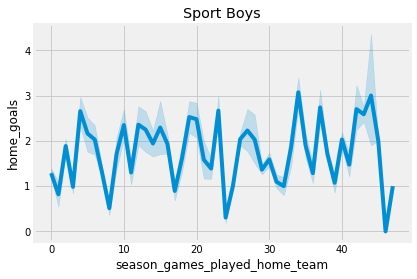

Text(0.5,1,'U. Pando')

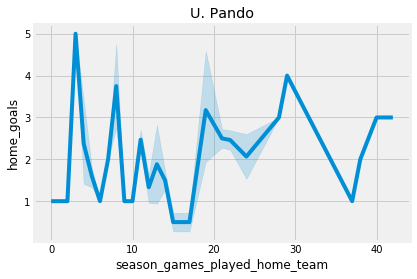

Text(0.5,1,'Ciclon')

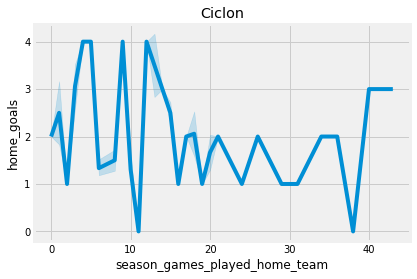

Text(0.5,1,'Royal Pari')

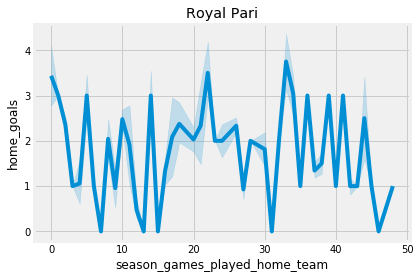

Text(0.5,1,'Always Ready')

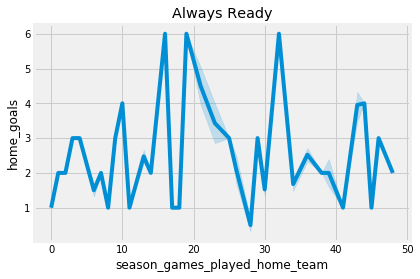

In [408]:
# game of season (home) vs. goals scored

for team in odds.home_team.unique():
    fig, axes = plt.subplots(figsize=(6,4))
    sns.lineplot(data=odds.loc[(odds['home_team'] == team)|(odds['away_team'] == team)],
                 x='season_games_played_home_team',
                 y='home_goals')
    plt.title(team)
    plt.show();

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


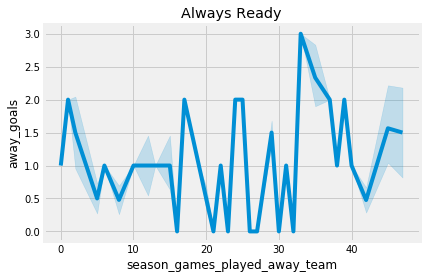

In [410]:
# game of season (away) vs. goals scored

sns.lineplot(data=odds.loc[(odds['home_team'] == team)|(odds['away_team'] == team)],
                 x='season_games_played_away_team',
                 y='away_goals')
plt.title(team)
plt.show();

### Bookmakers
This section wil focus on graphing the bookmaker odds in order to find interesting trends and patterns in how the casinos set the money lines for individual matches

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


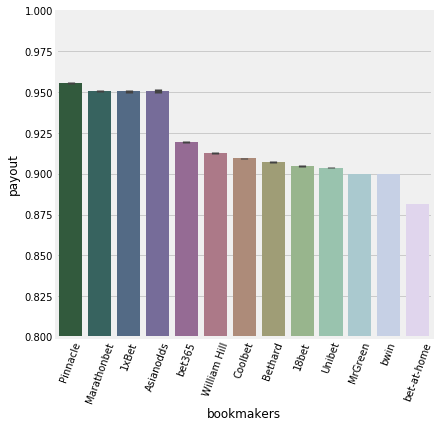

In [89]:
# Bookie average payout
fig, axes = plt.subplots(figsize=(6,6))


sns.barplot(data=odds, x='bookmakers', y='payout',
            order=odds.groupby('bookmakers')['payout'].mean().sort_values(ascending=False).index,
            palette=palette
           )

axes.set_ylim((.8,1))
plt.xticks(rotation=70);

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


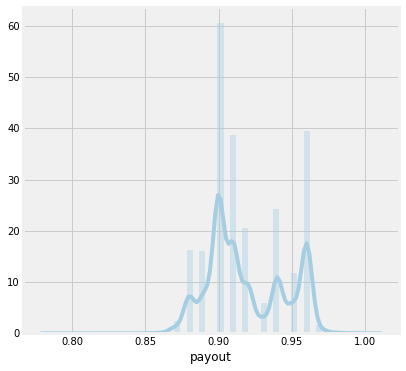

In [90]:
# Distplot of payout
fig, axes = plt.subplots(figsize=(6,6))
sns.distplot(odds['payout']);

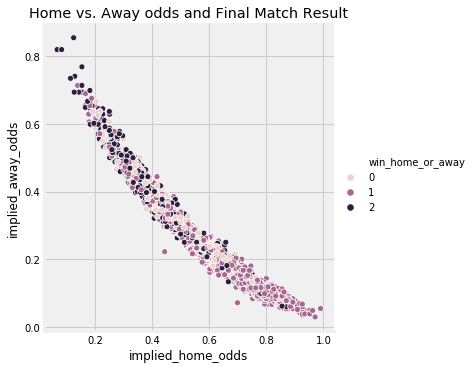

In [401]:
# Average odds for each team vs final result

sns.relplot(data=odds_unique_matches, x='implied_home_odds',y='implied_away_odds',hue='win_home_or_away')
plt.title('Home vs. Away odds and Final Match Result');

#plt.legend(['Draw', 'Home', 'Away']);

In [91]:
odds.columns

Index(['match', 'match_href', 'bookmakers', 'home_odds', 'draw_odds',
       'away_odds', 'payout', 'date', 'time', 'season_year', 'home_team',
       'away_team', 'final_result', 'home_goals', 'away_goals',
       'first_half_home', 'first_half_away', 'second_half_home',
       'second_half_away', 'total_goals', 'total_first_half',
       'total_second_half', 'win_home_or_away', 'winner', 'home_win',
       'away_win', 'home_loss', 'away_loss', 'implied_home_odds',
       'implied_draw_odds', 'implied_away_odds', 'upset', 'altitude',
       'cumulative_home_win', 'cumulative_away_win', 'cumulative_home_loss',
       'cumulative_away_loss', 'season_wins_home_team',
       'season_wins_away_team', 'season_losses_home_team',
       'season_losses_away_team', 'game_of_season_home_team',
       'game_of_season_away_team'],
      dtype='object')

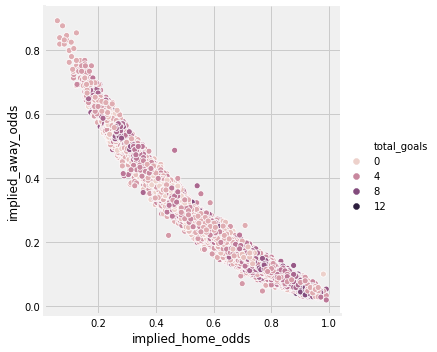

In [414]:
sns.relplot(data=odds, x='implied_home_odds', y='implied_away_odds',hue='total_goals');

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


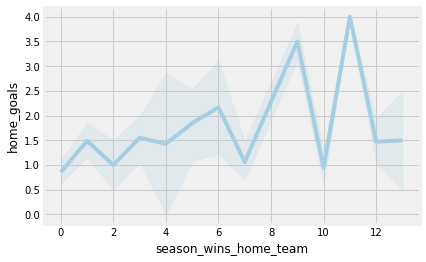

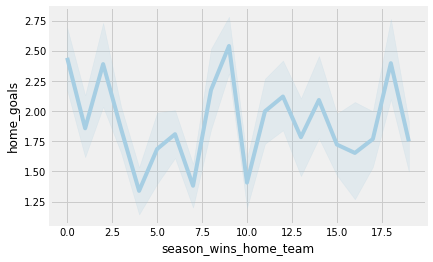

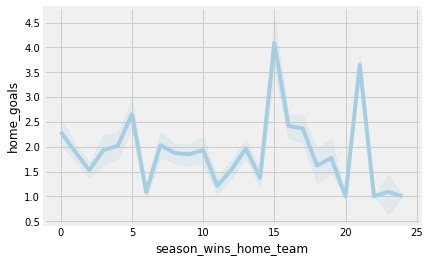

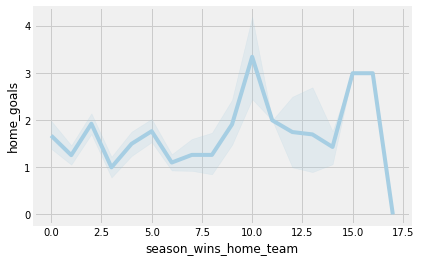

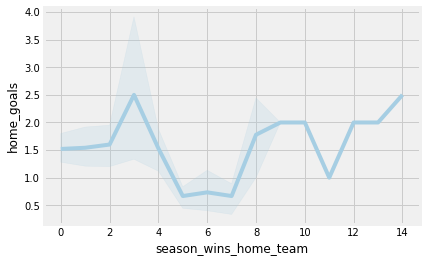

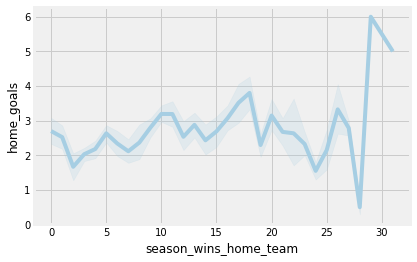

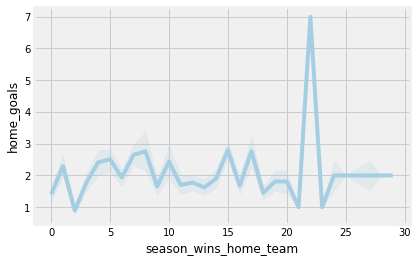

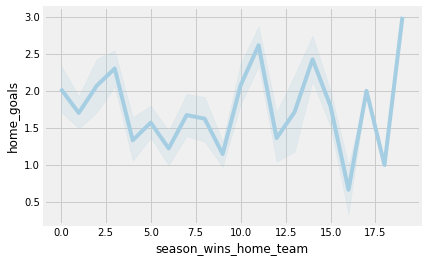

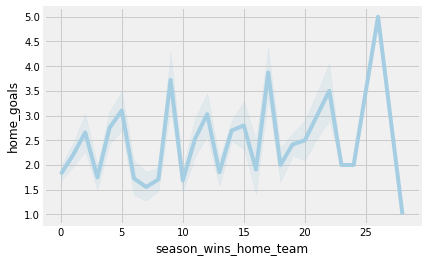

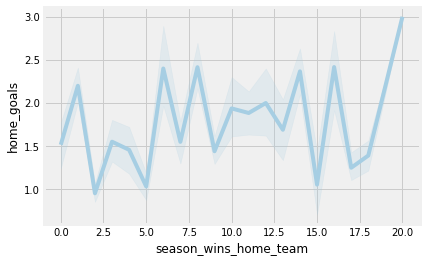

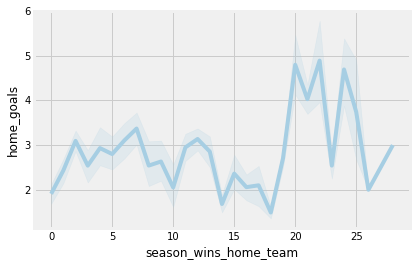

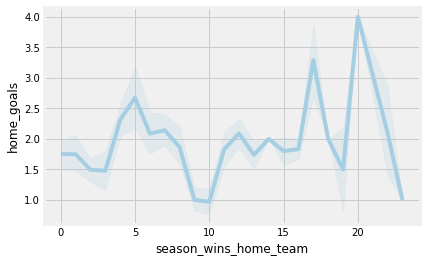

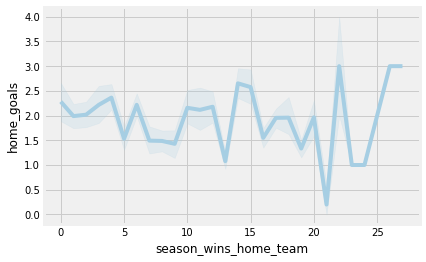

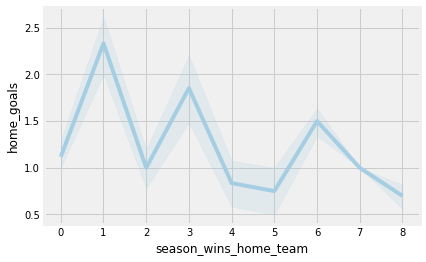

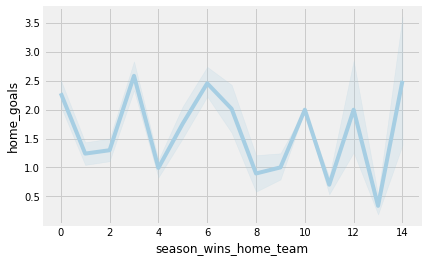

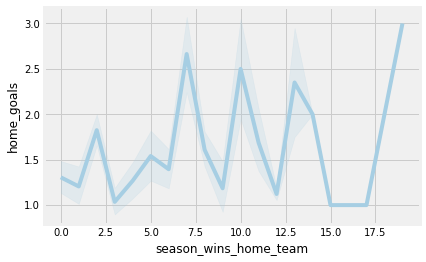

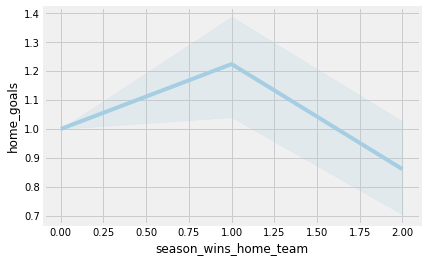

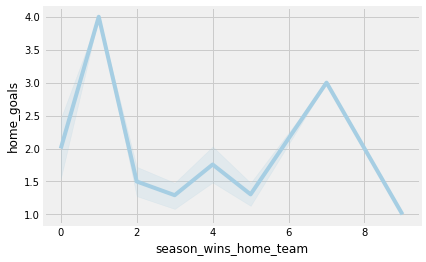

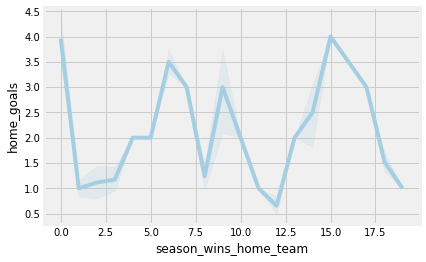

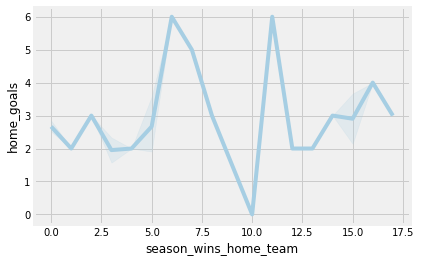

In [93]:
# wins vs. goals
for team in odds.home_team.unique():
    fig, axes = plt.subplots(figsize=(6,4))
    sns.set_palette("Paired")
    sns.lineplot(data=odds.loc[odds['home_team'] ==team] , x='season_wins_home_team', y='home_goals')
    plt.show();

Text(0.5,1,'Always Ready')

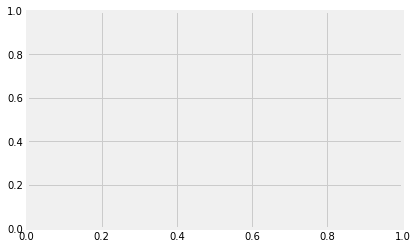

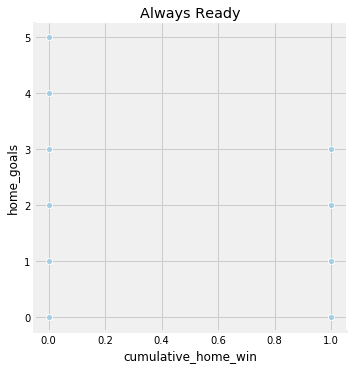

Text(0.5,1,'Always Ready')

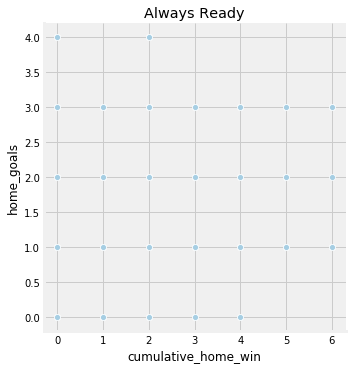

Text(0.5,1,'Always Ready')

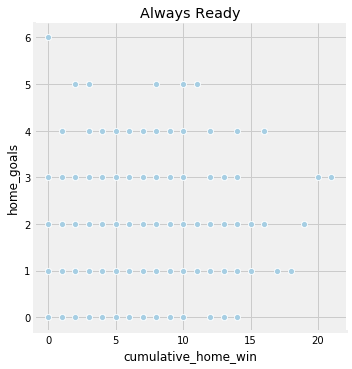

Text(0.5,1,'Always Ready')

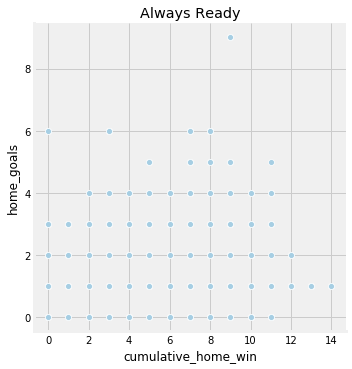

Text(0.5,1,'Always Ready')

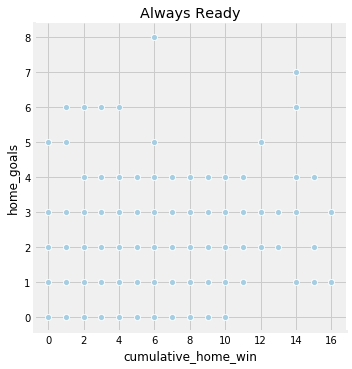

Text(0.5,1,'Always Ready')

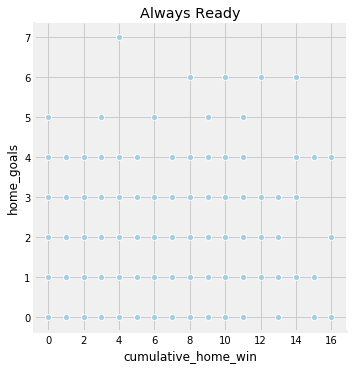

Text(0.5,1,'Always Ready')

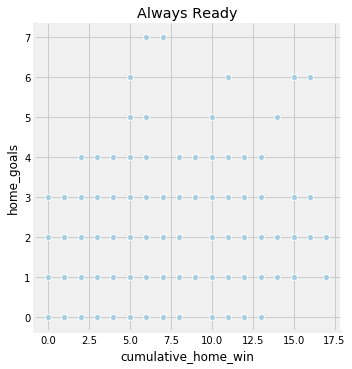

Text(0.5,1,'Always Ready')

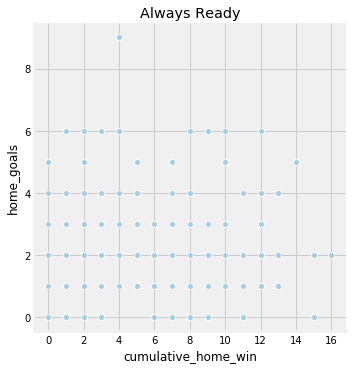

Text(0.5,1,'Always Ready')

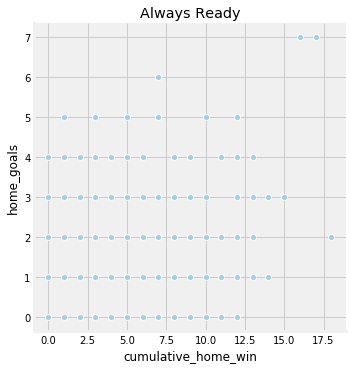

Text(0.5,1,'Always Ready')

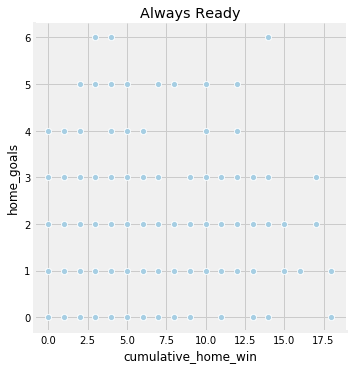

Text(0.5,1,'Always Ready')

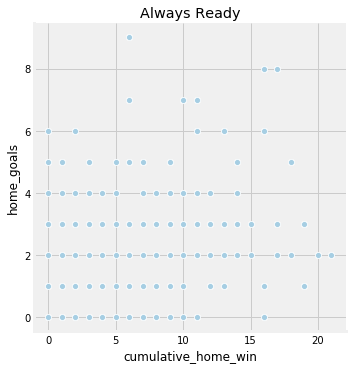

Text(0.5,1,'Always Ready')

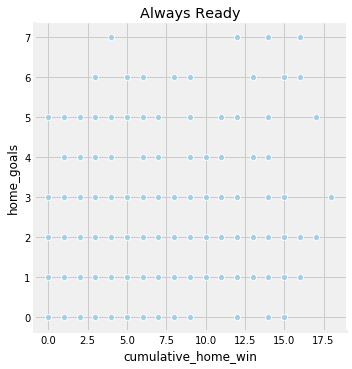

In [94]:
fig, axes = plt.subplots(figsize=(6,4))
sns.set_palette("Paired")
for year in odds.season_year.unique():
    sns.relplot(data=odds.loc[odds['season_year'] ==year] , x='cumulative_home_win', y='home_goals')
    plt.title(team)
    plt.show();

In [384]:
odds.to_csv('/Users/miketondu/Dropbox/Data Science/Sharpest Minds/odds_data/bolivian_football_odds_prepared.csv', index=False)

In [ ]:
odds.head()